In [14]:
import pandas as pd
df = pd.read_csv('train_data.csv')

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV # used to calibrate a classifier's predicted prob to see if it accurately reflects true likelihood
from sklearn.pipeline import Pipeline # chaining together preprocessing and the model into one object
from sklearn.preprocessing import StandardScaler # zeroes out the mean and scales to unit variance
from xgboost import XGBRegressor # gradient-boosted decision tree classifier that outputs probabilities
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import numpy as np


features = ['W_PCT_diff', 'elo_diff', 'is_home']
diff_columns = []
for i in features:
    diff_columns.append(f'{i}')

X = df[diff_columns]

Y = df['PTS_AWAY'] - df['PTS']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('xgb', XGBRegressor(
        n_estimators=100, # how mant trees are made / # of iterations
        max_depth=2, # how deep the tree is (max depth of each tree)
        learning_rate=0.051, #
        subsample=0.6, # % of how much of the training data is sampled (helps reduce overfitting)
        colsample_bytree=0.6, # % of features randomly sampled for each tree -> prevent any strong feature from dominating
    ))
])



pipe.fit(X_train, Y_train)

y_pred = pipe.predict(X_test)

In [8]:
import pandas as pd
from xgboost import XGBRegressor

# 1) Fit a blind model on all features
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=2,
    learning_rate=0.051,
    subsample=0.6,
    colsample_bytree=0.6,
    use_label_encoder=False,
    verbosity=0
)
model.fit(X_train, Y_train)

# 2) Pull out importance scores
importances = pd.Series(
    model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print("Feature importances:\n", importances)

# 3) Pick your top-k
top_features = importances.head(5).index.tolist()
print("Top 5 features:", top_features)


Feature importances:
 elo_diff         0.404667
W_PCT_diff       0.170075
is_home          0.132814
momentum_5       0.093175
PTS_RANK_diff    0.073249
AST_RANK_diff    0.064541
REB_RANK_diff    0.061479
dtype: float32
Top 5 features: ['elo_diff', 'W_PCT_diff', 'is_home', 'momentum_5', 'PTS_RANK_diff']


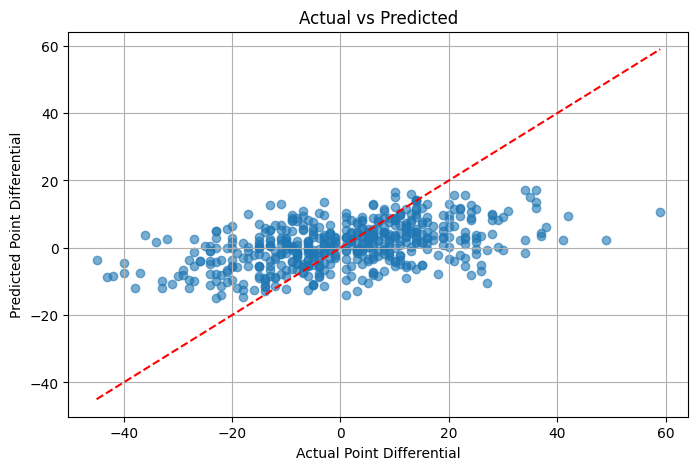

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(Y_test, y_pred, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')  # Perfect prediction line
plt.xlabel('Actual Point Differential')
plt.ylabel('Predicted Point Differential')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()


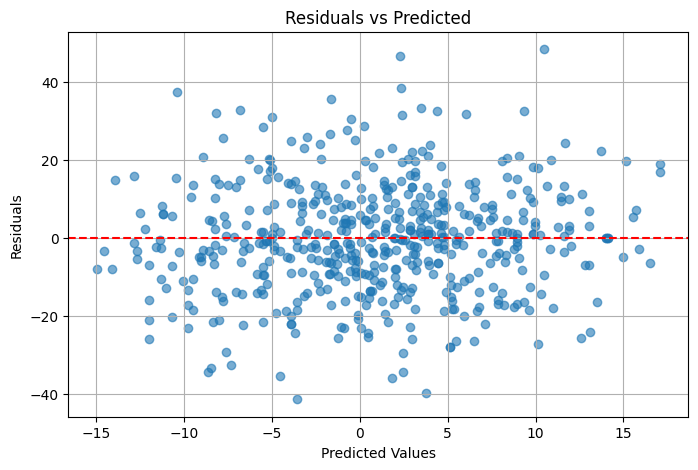

In [21]:
residuals = Y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.grid(True)
plt.show()


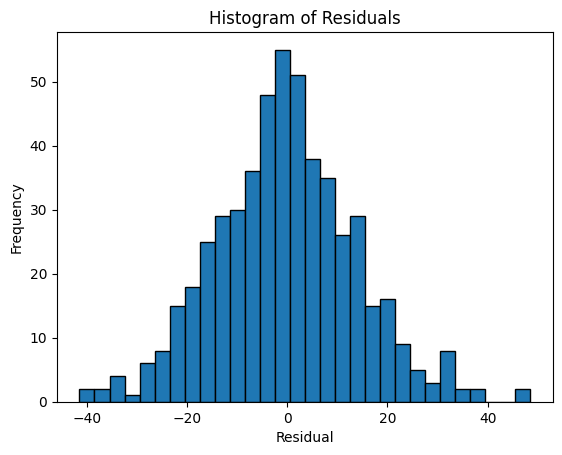

In [22]:
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()


In [23]:
from joblib import dump
dump(pipe, 'spread_model.joblib')

['spread_model.joblib']